In [0]:
#!pip install mahotas
import mahotas as mh
import matplotlib.pyplot as plt
import numpy as np

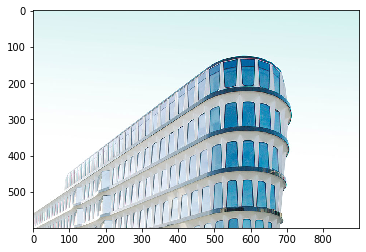

In [0]:
arch = mh.imread('data/arch.jpg')
plt.imshow(arch)

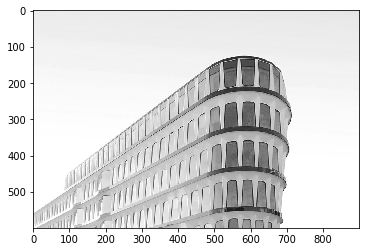

In [0]:
bin_arch = mh.colors.rgb2gray(arch, dtype=np.uint8)
plt.imshow(bin_arch)
plt.gray()

Порог изображения = 178


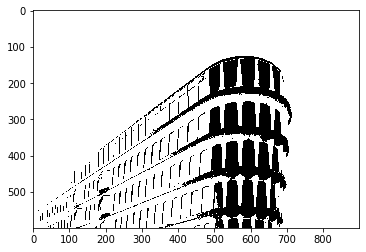

In [0]:
threshold = mh.thresholding.otsu(bin_arch)
print(f'Порог изображения = {threshold}')
plt.imshow(bin_arch > threshold);

### Гауссово размытие

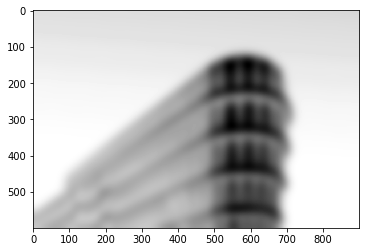

In [0]:
arch_gauss = mh.gaussian_filter(bin_arch, 13)
plt.imshow(arch_gauss);

Порог изображения = 191


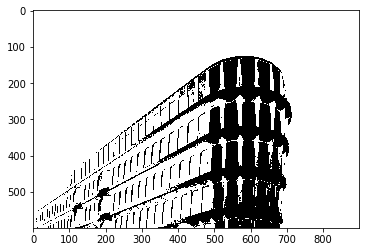

In [0]:
# Оцу к размытому изображению
threshold_gauss = mh.thresholding.otsu(arch_gauss.astype('uint8'))
print(f'Порог изображения = {threshold_gauss}')
plt.imshow(bin_arch > threshold_gauss);

### Размытие границ. Помещение центра в фокус

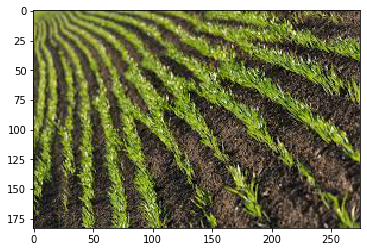

In [0]:
minim = mh.imread('data/minim.jpg')
plt.imshow(minim);

In [0]:
r,g,b = minim.transpose(2,0,1)
r12 = mh.gaussian_filter(r, 12.)
g12 = mh.gaussian_filter(g, 12.)
b12 = mh.gaussian_filter(b, 12.)
rgb12 = mh.as_rgb(r12, g12, b12)

In [0]:
h, w = r.shape
Y, X = np.mgrid[:h, :w]

In [0]:
Y = (Y - h/2.) / Y.max()
X = (X - w/2.) / X.max()

In [0]:
C = np.exp(-2. * (X**2 + Y**2))
C = (C - C.min()) / C.ptp()
C = C[:,:,None]

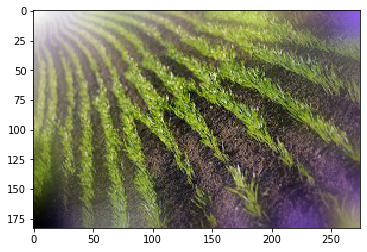

In [0]:
focused_minim = mh.stretch(minim*C + (1-C)*rgb12)
plt.imshow(focused_minim);

### Классификация изображений

In [0]:
# features
building = mh.imread('simple_dataset/building05.jpg')

features = mh.features.haralick(building)
mean_features = np.mean(features, axis=0)
all_features = np.ravel(mean_features)
all_features

array([ 4.98941352e-04,  7.44715436e+01,  9.91144567e-01,  4.20779301e+03,
        2.32773142e-01,  2.46031546e+02,  1.67567005e+04,  8.41341236e+00,
        1.20417610e+01,  3.78328051e-04,  3.91091658e+00, -3.81540848e-01,
        9.97572236e-01])

In [0]:
from glob import glob
images = glob('simple_dataset/*.jpg')
features_list = []
labels = []
for im in images:
    labels.append(im[:-len('00.jpg')])
    im = mh.imread(im)
    im = mh.colors.rgb2gray(im, dtype=np.uint8)
    features_list.append(mh.features.haralick(im).ravel())
features_arr = np.array(features_list)
labels_arr = np.array(labels)

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
clf = Pipeline([('preprocessing', StandardScaler()),
                ('calssifier', LogisticRegression())])
import warnings
warnings.filterwarnings('ignore')

In [0]:
from sklearn.model_selection import cross_validate, LeaveOneOut, cross_val_score
loo = LeaveOneOut()
cv = int(loo.get_n_splits(images) / 3)
scores = cross_val_score(clf, features_arr, labels_arr, cv=cv)
print(f'Точность : {scores.mean()}')

Точность : 0.8222222222222223


### Создаем собственные признаки

In [0]:
def chist(img):
    img = img // 64
    r,g,b = img.transpose((2,0,1))
    pixels = r + 4 * b + 16 * g
    hist = np.bincount(pixels.ravel(), minlength=64)
    hist = hist.astype(float)
    return np.log1p(hist)


In [0]:
features_new = []
for img in images:
    imcolor = mh.imread(img)
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features_new.append(np.concatenate([
                mh.features.haralick(im).ravel(),
                chist(imcolor),
    ]))

In [0]:
new_scores = cross_val_score(clf, features_new, labels_arr, cv=cv)
print(f'Теперь точность = {new_scores.mean()}')

Теперь точность = 0.9666666666666667


### Поиск похожих изображений. Уменьшаем признаки, обрезая края

In [0]:
features_alike = []
for im in images:
    imcolor = mh.imread(im)
    imcolor = imcolor[200:-200, 200:-200]
    im = mh.colors.rgb2gray(imcolor, dtype=np.uint8)
    features_alike.append(np.concatenate([
                mh.features.haralick(im).ravel(),
                chist(imcolor),
    ]))

In [0]:
# нормализуем признаки
from scipy.spatial import distance

sc = StandardScaler()
features_sc = sc.fit_transform(features_alike)
dist = distance.squareform(distance.pdist(features_alike))

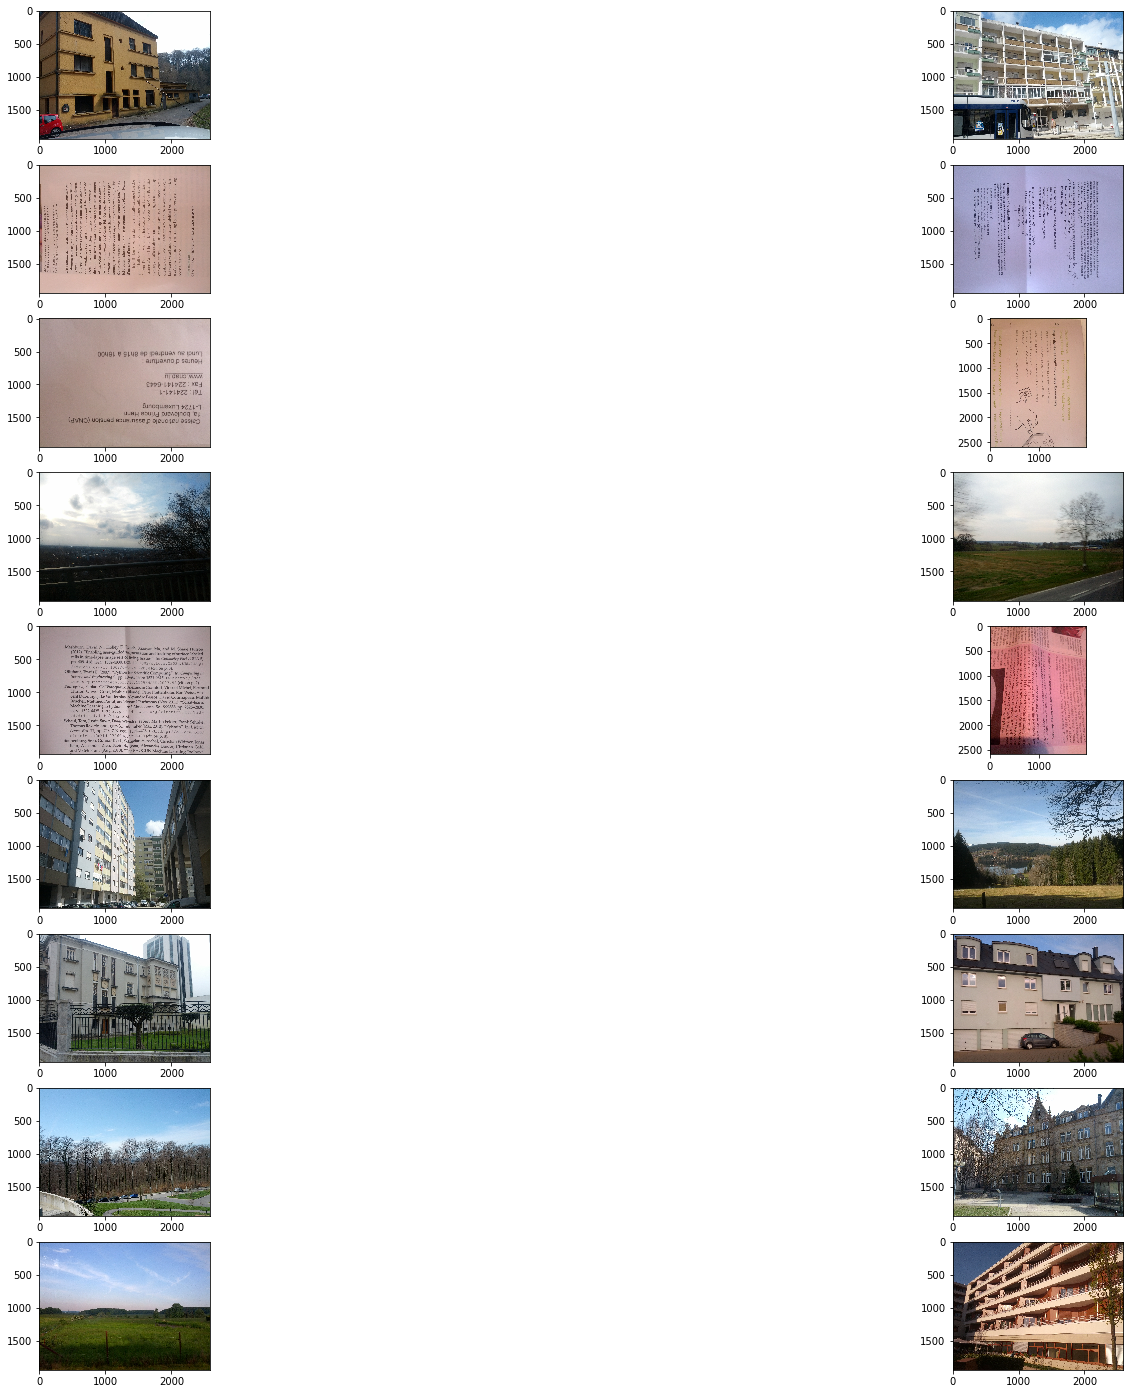

In [0]:
# теперь для каждого изображения наверху выводим похожее изображение снизу

fig, axes = plt.subplots(9,2, figsize=(30, 25))

for ci, i in enumerate(range(0,90,10)):
    left = images[i]
    dist_left = dist[i]
    right = dist_left.argsort()
    right = right[1]
    right = images[right]
    left = mh.imread(left)
    right = mh.imread(right)
    axes[ci, 0].imshow(left)
    axes[ci, 1].imshow(right)

### Локальные представления признаков

In [0]:
from mahotas.features import surf
img = mh.imread('data/minim.jpg')
img = mh.colors.rgb2gray(img, dtype=np.uint8)
descriptors = surf.surf(img, descriptor_only=True)

In [0]:
descriptors

array([[-0.00100144, -0.00072007,  0.00198342, ...,  0.00075365,
         0.00464511,  0.00512583],
       [-0.00039647,  0.00081336,  0.00193928, ..., -0.0031293 ,
         0.00497736,  0.00441385],
       [ 0.00117023, -0.00135245,  0.00335601, ..., -0.00118446,
         0.01654917,  0.00475133],
       ...,
       [ 0.00344413, -0.00109558,  0.0074331 , ...,  0.01515015,
         0.033474  ,  0.01750168],
       [ 0.00809649, -0.00131389,  0.01097141, ..., -0.00497811,
         0.01508009,  0.01319193],
       [-0.00148285, -0.0033768 ,  0.00359603, ..., -0.0125879 ,
         0.00727875,  0.01268277]])

In [0]:
alldescriptors = []
for img in images:
    img = mh.imread(img, as_grey = True)
    img = img.astype(np.uint8)
    alldescriptors.append(surf.dense(img, spacing=16))
concatenated = np.concatenate(alldescriptors)
print(f'Количество локальных дескрипторов = {len(concatenated)}')

Количество локальных дескрипторов = 1580040


In [0]:
# надем центроиды при помощи метода кластеризации (K-means)
from sklearn.cluster import KMeans

concatenated_64 = concatenated[::64] #  every 64th vector
k = 256
km = KMeans(k)
km.fit(concatenated_64)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=256, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
sfeatures = []
for descript in alldescriptors:
    class_ = km.predict(descript)
    sfeatures.append(
        np.array([np.sum(class_ == cl) for cl in range(k)])
    )
sfeatures = np.array(sfeatures, dtype=float)

In [0]:
scores = cross_val_score(clf, sfeatures, labels_arr, cv=cv)
print(f'Точность = {scores.mean()}')

Точность = 0.9777777777777779


In [0]:
# объединяем признаки
combinated = np.hstack([features_new, sfeatures])
scores = cross_val_score(clf, combinated, labels_arr, cv=cv)
print(f'Точность = {scores.mean()}')

Точность = 0.9888888888888889
